In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os 
os.chdir('/content/drive/MyDrive/image captioning /Pytorch_lightning')

In [3]:
!ls 

data  icap  logs  saved_model  train_inference.ipynb  train_v2.ipynb


In [4]:
!pip install pytorch-lightning

     |████████████████████████████████| 525 kB 5.2 MB/s 
     |████████████████████████████████| 829 kB 35.6 MB/s 
     |████████████████████████████████| 132 kB 35.2 MB/s 
     |████████████████████████████████| 332 kB 45.8 MB/s 
     |████████████████████████████████| 596 kB 38.7 MB/s 
     |████████████████████████████████| 1.1 MB 21.2 MB/s 
     |████████████████████████████████| 160 kB 45.2 MB/s 
     |████████████████████████████████| 192 kB 45.9 MB/s 
     |████████████████████████████████| 271 kB 48.9 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=d417903b0afca59459729bef85e21b590c1590bf336c90891a520ad764be0e02
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found exis

In [5]:
import pytorch_lightning 

In [6]:
pytorch_lightning.__version__

'1.5.6'

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from icap import data, models, task, utils

import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from torchmetrics import Accuracy

In [8]:
!pwd

/content/drive/MyDrive/image captioning /Pytorch_lightning


In [10]:
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
BATCH_SIZE = 32
NUM_WORKERS = 8
SPLIT_VAL = 0.2

EMBED_SIZE = 256
HIDDEN_SIZE = 256
NUM_LAYERS = 1

LRATE = 3e-5
MAX_EPOCHS = 30
NUM_GPU=1

In [11]:
train_transform = transforms.Compose([
    transforms.Resize((356, 356)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
])

root_dir = "data/flickr8k/images/"
caption_file = "data/flickr8k/captions.txt"

train_loader, trainset = data.flickr_dataloader(root_dir, caption_file, transform=train_transform, batch_size = BATCH_SIZE, 
                                                num_workers=NUM_WORKERS, shuffle=True, train=True)

valid_loader, validset = data.flickr_dataloader(root_dir, caption_file, transform=valid_transform, batch_size = BATCH_SIZE, 
                                                num_workers=NUM_WORKERS, shuffle=False, train=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [12]:
len(train_loader)

1012

In [13]:
len(valid_loader)

253

In [14]:
# initialize model, loss etc
PAD_INDEX = trainset.vocab.stoi["<PAD>"]
VOCAB_SIZE = len(trainset.vocab)
print(f'VOCAB_SIZE : {VOCAB_SIZE}')

model = models.ImageCaptionNet(EMBED_SIZE, HIDDEN_SIZE, VOCAB_SIZE, NUM_LAYERS)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_INDEX)
optimizer = optim.Adam(model.parameters(), lr=LRATE)
trainer_task = task.ImageCaptionTask(model, optimizer, criterion, vocab_size=VOCAB_SIZE)

VOCAB_SIZE : 2994


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [15]:
PAD_INDEX

0

In [16]:
checkpoint_path = '/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model'
# DEFAULTS used by the Trainer
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=checkpoint_path,
    filename = 'flickr8k_net_{epoch}',
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min',
)

tensorboard_logger = pl_loggers.TensorBoardLogger('/content/drive/MyDrive/image captioning /Pytorch_lightning/logs/test')

trainer = pl.Trainer(max_epochs=MAX_EPOCHS, gpus=NUM_GPU, 
                     logger=tensorboard_logger, callbacks=[checkpoint_callback])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [17]:
trainer.fit(trainer_task, train_loader, valid_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ImageCaptionNet  | 26.1 M
1 | criterion | CrossEntropyLoss | 0     
2 | metric    | Accuracy         | 0     
-----------------------------------------------
2.6 M     Trainable params
23.5 M    Non-trainable params
26.1 M    Total params
104.381   Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:623: UserWarning: Checkpoint directory /content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:60: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:60: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 27. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"
Epoch 0, global step 1011: val_loss reached 5.07487 (best 5.07487), saving model to "/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=0.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 2023: val_loss reached 4.63547 (best 4.63547), saving model to "/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 3035: val_loss reached 4.34985 (best 4.34985), saving model to "/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=2.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 4047: val_loss reached 4.09535 (best 4.09535), saving model to "/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=3.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 5059: val_loss reached 3.91321 (best 3.91321), saving model to "/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=4.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 6071: val_loss reached 3.76819 (best 3.76819), saving model to "/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=5.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 7083: val_loss reached 3.64280 (best 3.64280), saving model to "/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=6.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 8095: val_loss reached 3.53973 (best 3.53973), saving model to "/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=7.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 9107: val_loss reached 3.46120 (best 3.46120), saving model to "/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=8.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 10119: val_loss reached 3.39411 (best 3.39411), saving model to "/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=9.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 11131: val_loss reached 3.34004 (best 3.34004), saving model to "/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=10.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 12143: val_loss reached 3.29174 (best 3.29174), saving model to "/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=11.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 13155: val_loss reached 3.24854 (best 3.24854), saving model to "/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=12.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 14167: val_loss reached 3.20800 (best 3.20800), saving model to "/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=13.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 15179: val_loss reached 3.17244 (best 3.17244), saving model to "/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=14.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 16191: val_loss reached 3.13848 (best 3.13848), saving model to "/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=15.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 17203: val_loss reached 3.10742 (best 3.10742), saving model to "/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=16.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 18215: val_loss reached 3.07837 (best 3.07837), saving model to "/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=17.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 19227: val_loss reached 3.05106 (best 3.05106), saving model to "/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=18.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 20239: val_loss reached 3.02526 (best 3.02526), saving model to "/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=19.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 21251: val_loss reached 3.00108 (best 3.00108), saving model to "/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=20.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 22263: val_loss reached 2.97975 (best 2.97975), saving model to "/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=21.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 23275: val_loss reached 2.95737 (best 2.95737), saving model to "/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=22.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 23, global step 24287: val_loss reached 2.93802 (best 2.93802), saving model to "/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=23.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 24, global step 25299: val_loss reached 2.91761 (best 2.91761), saving model to "/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=24.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 25, global step 26311: val_loss reached 2.90120 (best 2.90120), saving model to "/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=25.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 26, global step 27323: val_loss reached 2.88300 (best 2.88300), saving model to "/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=26.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 27, global step 28335: val_loss reached 2.86656 (best 2.86656), saving model to "/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=27.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 28, global step 29347: val_loss reached 2.85309 (best 2.85309), saving model to "/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=28.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 29, global step 30359: val_loss reached 2.83584 (best 2.83584), saving model to "/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=29.ckpt" as top 1


# Inference

In [18]:
best_model = models.ImageCaptionNet(EMBED_SIZE, HIDDEN_SIZE, VOCAB_SIZE, NUM_LAYERS)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_INDEX)
optimizer = optim.Adam(best_model.parameters(), lr=LRATE)
best_task = task.ImageCaptionTask(best_model, optimizer, criterion, vocab_size=VOCAB_SIZE)

In [19]:
saved_checkpoint_path = '/content/drive/MyDrive/image captioning /Pytorch_lightning/saved_model/flickr8k_net_epoch=29.ckpt'
checkpoint = torch.load(saved_checkpoint_path, map_location=lambda storage, loc: storage)
best_task.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [30]:
def inference(index, imtest):
  img, text = validset[index]
  IMG_MEAN = [0.485, 0.456, 0.406]
  IMG_STD = [0.229, 0.224, 0.225]
  mean = torch.tensor(IMG_MEAN, device=img.device, dtype=img.dtype).view(1, -1, 1, 1)
  std = torch.tensor(IMG_STD, device=img.device, dtype=img.dtype).view(1, -1, 1, 1)
  origin_image = img * std + mean
  imtest.show_result(origin_image, text)

predicted    :  a man is jumping on a rock .
ground truth :  a man and two boys jump on a trampoline .


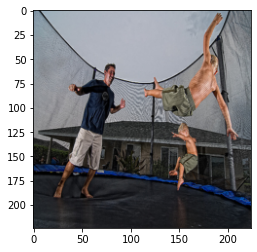

In [31]:
imtest = utils.ImageCaptionTest(best_model, validset.vocab)
inference(200, imtest)

predicted    :  a dog is running through the grass .
ground truth :  large dog plays with two smaller dogs on grass .


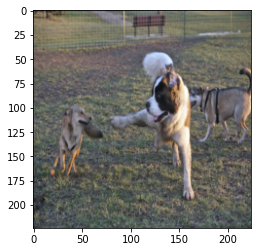

In [33]:
inference(41, imtest)

predicted    :  a group of people are playing in the water .
ground truth :  the two boys play in the field .


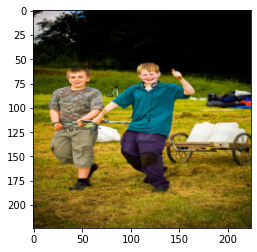

In [35]:
inference(40, imtest)

predicted    :  a man is riding a bike on a dirt hill .
ground truth :  an atv attempts to get out of a ditch .


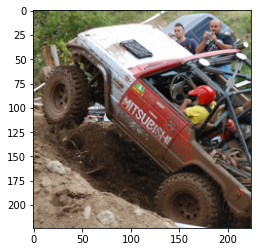

In [38]:
inference(12, imtest)

predicted    :  a group of people are standing on a street .
ground truth :  several young people walking <UNK> around


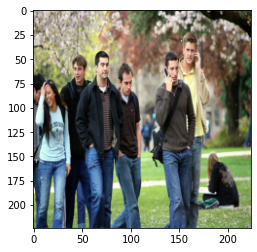

In [43]:
inference(6, imtest)

predicted    :  a man is jumping through the air .
ground truth :  the bmx rider wearing a black helmet gets air off of a jump .


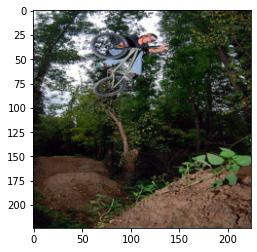

In [44]:
inference(1000, imtest)

In [ ]:
# BLEU Score 
# If you want to compute the BLEU score, comment line 58-60 in utils.py 
# then do the following code 
from nltk.translate.bleu_score import corpus_bleu
candidate_corpus = []
reference_corpus = []
for i in range(len(validset)):
  candidate, reference = inference(i, imtest)
  candidate_corpus.append(candidate.split())
  reference_corpus.append([reference.split()])
corpus_bleu(reference_corpus, candidate_corpus, weights = (1, 0, 0, 0)) # BLEU-1
corpus_bleu(reference_corpus, candidate_corpus, weights = (0.5, 0.5, 0, 0)) # BLEU-2
corpus_bleu(reference_corpus, candidate_corpus, weights = (0.33, 0.33, 0.33, 0)) # BLEU-3
corpus_bleu(reference_corpus, candidate_corpus, weights = (0.25, 0.25, 0.25, 0.25)) # BLEU-4